<h1 style="font-size:2em;color:#2467C0">Análisis del uso de Tumblr a través de Técnicas de Aprendizaje Automático Relacionados al Bienestar Digital (Well-Being)</h1>

###  Myriam Adriana Herrera Valero
<p>Trabajo de Fin de Máster</p>
<p>Máster en Analítica de Negocio y Grandes Volúmenes de Datos</p>
<p><b>UNIVERSIDAD DE ALCALÁ</b></p>

<p><b>Summary</b></p>
A través de la API de Tumblr en Python se recopilaron los datos de los tags más populares que la pagina Fandometrics publicó para la semana en revisión; utilizando las librerías de pandas/dask se realizó el análisis exploratorio, con el análisis de texto se determinó el sentimiento, se realizó modelo para clasificación del sentimiento. Lo siguiente fue determinar un matriz con las variables predictoras, para determinar si las publicaciones son depresivas o no.
El modelo es entrenado con cuatro (4) algoritmos de clasificación, Multinomial Naive Bayes, Random Forest, Voting Classifier y XgBoost. Los resultados preliminares se evaluaron para las publicaciones de lo tags tendencia en Tumblr (alrededor de 100 tags), en un periodo de 365 días, trayendo para el análisis más de 200.000 publicaciones, el modelo propuesto alcanzó una precisión de clasificación del 76%.


# Indice

1. <a href='#section1.0'>Requisitos previos</a>
2. <a href='#section2.0'>Importar paquetes</a><br />   
3. <a href='#section3.0'>Dask Client </a><br />    
4. <a href='#section4.0'>Lectura de Archivos</a><br />   
5. <a href='#section5.0'>Identificación de Nulos </a><br />    
6. <a href='#section6.0'>Carga de Datos en Dask </a><br />    
7. <a href='#section7.0'>Exploración de Datos </a><br />
8. <a href='#section8.0'>Tokenización </a><br />
9. <a href='#section9.0'>Remover Stop Words </a><br />
10. <a href='#section10.0'>Steaming y Lematización Words </a><br />
11. <a href='#section11.0'>Polaridad y Detección de Lexico </a><br />
12. <a href='#section12.0'>Lenguaje Depresivo </a><br />
13. <a href='#section13.0'>Deficición de Variables </a><br />
14. <a href='#section14.0'>Modelos</a><br />
15. <a href='#section15.0'>Conclusiones</a><br />

<a id='section1.0'></a>
### 1. Requisitos previos

Instalar los siguientes complementos
<p>pip install dask</p>
<p>pip install glob</p>
<p>pip install dask[dataframe] --upgrade</p>
<p>pip install dask-ml</p>
<p>pip install nltk</p>
<p>pip install gensim</p>
<p>pip install wordcloud</p>
<p>pip install dask-xgboost</p>

<a id='section2.0'></a>
### 2. Importar paquetes

In [3]:
import pandas as pd
import numpy as np
import os, json
import glob
from timeit import timeit
from datetime import date
import dask.dataframe as dd
from dask.diagnostics import ProgressBar
import dask.array as da

import re,string
import gensim
#import gensim.corpora as corpora
#from gensim import models
from gensim.utils import simple_preprocess
#from gensim.models import CoherenceModel
import nltk
import nltk.corpus
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import wordnet

import seaborn as sns
import matplotlib.pyplot as plt

<a id='section3.0'></a>
### 3. Dask Client

In [4]:
from dask.distributed import Client, progress   
client = Client()
client


Client Scheduler: tcp://127.0.0.1:51709,Cluster Workers: 4 Cores: 4 Memory: 12.75 GB


<a id='section4.0'></a>
### 4. Lectura de Archivos

In [5]:
path_to_json = 'Data/'
json_files = [pos_json for pos_json in os.listdir(path_to_json) if  pos_json.endswith('.json')]
print("Cantidad de archivos JSON a procesar: ", len(json_files))

Cantidad de archivos JSON a procesar:  15050


In [6]:
%%time
df = pd.concat([pd.read_json(f) for f in glob.glob('Data/*.json')], ignore_index = True, sort=False)


Wall time: 10min 36s


In [5]:
print(df.columns)
print("Cantidad de registros: ",len(df), "   Cantidad de columnas: ",len(df.columns))
#df.head(4)

Index(['blog', 'blog_name', 'body', 'can_like', 'can_reblog', 'can_reply',
       'can_send_in_message', 'caption', 'date', 'description',
       'display_avatar', 'excerpt', 'followed', 'format', 'id',
       'image_permalink', 'liked', 'link_author', 'note_count', 'photos',
       'photoset_layout', 'post_author', 'post_url', 'publisher', 'reblog',
       'reblog_key', 'recommended_color', 'recommended_source', 'short_url',
       'should_open_in_legacy', 'slug', 'state', 'summary', 'tags',
       'timestamp', 'title', 'trail', 'type', 'url', 'source_title',
       'source_url', 'is_submission', 'post_author_is_adult', 'link_image',
       'link_image_dimensions', 'answer', 'asking_name', 'asking_url',
       'question', 'caption_abstract', 'link_url', 'html5_capable',
       'permalink_url', 'player', 'thumbnail_height', 'thumbnail_url',
       'thumbnail_width', 'video', 'video_type', 'duration', 'video_url',
       'body_abstract', 'is_panorama', 'description_abstract', 'dialogue'

<a id='section5.0'></a>
### 5. Identificacion de Nulos

In [7]:
%%time
print(f'# of rows processing : {len(df)}')
print("\033[4m\nColumn Name\tisnull_counts\tdata_types\033[0m")
for columns in df.columns:
    print(f'{columns.ljust(17)}\t{(df[columns].isnull().sum()):>5}\t{(df[columns].dtype)}')
print('\t')

# of rows processing : 296185

Column Name	isnull_counts	data_types
blog             	    0	object
blog_name        	    0	object
body             	125606	object
can_like         	    0	bool
can_reblog       	    0	bool
can_reply        	    0	bool
can_send_in_message	    0	bool
caption          	189874	object
date             	    0	datetime64[ns]
description      	287926	object
display_avatar   	    0	bool
excerpt          	290275	object
followed         	172660	object
format           	    0	object
id               	    0	int64
image_permalink  	229263	object
liked            	172660	object
link_author      	294531	object
note_count       	    0	int64
photos           	194636	object
photoset_layout  	265428	float64
post_author      	288248	object
post_url         	    0	object
publisher        	287926	object
reblog           	 2653	object
reblog_key       	    0	object
recommended_color	296185	float64
recommended_source	296185	float64
short_url        	    0	object
should_open_in_le

In [8]:
df['cadena'] = ([' '.join(i) for i in zip(df['blog_name'],df['summary'], df['tags'].map(str))])

<a id='section6.0'></a>
### 6. Carga de datos en Dask

In [9]:
%%time
ddf = dd.from_pandas(df[['date','id','cadena','type','note_count']], npartitions=8) 
#ddf.head(4)

Wall time: 1.09 s


<a id='section7.0'></a>
### 7. Exploración de Datos

In [10]:
#Eliminiacion de duplicados
ddf=ddf.drop_duplicates().compute()
ddf.reset_index(drop=True, inplace=True)
#print(len(ddf))
#ddf.head()

c:\python\lib\site-packages\distributed\worker.py:3101: UserWarning: Large object of size 9.21 MB detected in task graph: 
  (                     date            id  \
0      ...  x 5 columns],)
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  % (format_bytes(len(b)), s)


In [11]:
#Creacion de variables fecha, mes, diasemana, hora, y horas_nocturnas
ddf = dd.concat([ddf,dd.to_datetime(ddf['date']).
                 apply(lambda x: pd.Series([x.date(),x.month,x.weekday(), x.hour],
                 index=['fecha' ,'mes','diasemana', 'hora']),
                       meta={'fecha': 'object', 'mes': 'int64','diasemana': 'int64', 'hora': 'int64'})], axis=1) 

ddf = dd.concat([ddf,ddf[['diasemana']].
                  apply(lambda x: pd.Series(1 if (x < 5).any() else 0, 
                                            index = ['dia_laborable']),axis=1,meta={'dia_laborable': 'int64'})], axis=1)

ddf = dd.concat([ddf,ddf[['hora']].
                  apply(lambda x: pd.Series(1 if (x >= 23).any() or (x <=6).any() else 0, 
                                            index = ['horas_nocturnas']),axis=1,meta={'horas_nocturnas': 'int64'})], axis=1)

In [12]:
#Codificación variable cualitativa tipo de publicación
from dask_ml import preprocessing 
le = preprocessing.LabelEncoder()
dtype = pd.DataFrame(le.fit_transform(ddf.type).compute())
dtype.rename(columns={0: 'type_x'}, inplace=True)
ddf = dd.concat([ddf,dtype],axis=1)


In [13]:
#Variables de frecuencia de publicaciones por hora, se determina 1 si es mayor a 3 publicaciones, de lo contrario 0
df_f = ddf[["fecha","hora"]]
df_f['f_hora'] = df_f['fecha'].map(str) + ' '+ df_f['hora'].map(str)
df1 =df_f.groupby('f_hora')['hora'].count().compute()
df1 = pd.DataFrame(data=df1)
df1.rename(columns={'hora': 'frec_hora'}, inplace=True)

df_f=df_f.compute()
df_f = pd.merge(df_f, df1, on =['f_hora'], how= 'inner')

ddf = dd.concat([ddf, df_f['frec_hora']] ,axis=1)

ddf = dd.concat([ddf,ddf[['frec_hora']].
                           apply(lambda x: pd.Series(1 if (x > 3).any() else 0 ,
                                                index = ['frecuencia']),axis=1, meta={'frecuencia':'int64'})],axis=1) 

In [14]:
ddf_type = ddf.groupby('type')['type_x'].count().compute()
df_type = pd.DataFrame(ddf_type).sort_values(by='type_x',ascending=False)

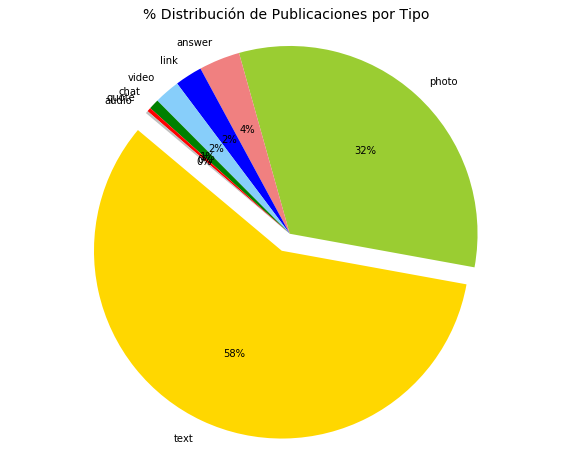

In [15]:
labels= df_type.index
value = df_type['type_x']
explode = (0.1, 0, 0, 0,0,0,0,0) 
colors = ['gold', 'yellowgreen', 'lightcoral','blue', 'lightskyblue','green','red','silver']

plt.figure(figsize=(10,8))
plt.title("% Distribución de Publicaciones por Tipo",fontsize=14)
plt.pie(value, labels=labels, startangle=140,colors=colors,explode=explode, autopct='%1.f%%')

plt.axis('equal')
plt.show()

*Se evidencia la distribucion de las publicaciones en Tumblr con un 90% en total entre fotos y texto; y un 10% entre las categorias de answer, link, video, chat, quote y audio.*

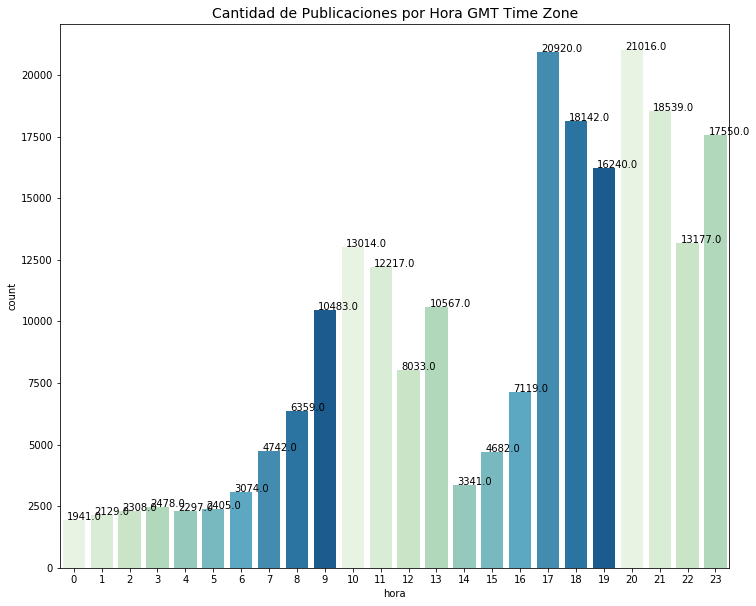

In [16]:
ddf_f = ddf[["hora"]]

fig, ax =plt.subplots(figsize=(12,10))
ax = sns.countplot(ddf_f['hora'].compute(),label="Count",palette=sns.color_palette("GnBu",10)) 
plt.title("Cantidad de Publicaciones por Hora GMT Time Zone",size=14)
for p in ax.patches:
        ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.15, p.get_height()+1))

*La tendencia de publicacion en horas del dia, evidencia que la cantidad de publicaciones aumenta en horas de la tarde, teniendo su pico mas alto entre las 5:00 pm y las 8:00 pm, hasta las 23 horas, donde luego se puede observar que la cantidad de publicaciones desciende. A simple vista se puede evidenciar que los horarios que presentan mayor cantidad de publicaciones estan relacionados a los tiempos de descanso o receso que tienen las personas en su dia laboral, por ejemplo en horas de la mañana el pico mas alto esta entre las 10 y la 1, que puede ser relacionado con la hora de la comida, y en la tarde despues de que se termina la jornada laboral. Esto podria empezar a guiarnos en cuanto Wellbeing de las personas, en cuanto como usan su tiempo libre en las redes.*

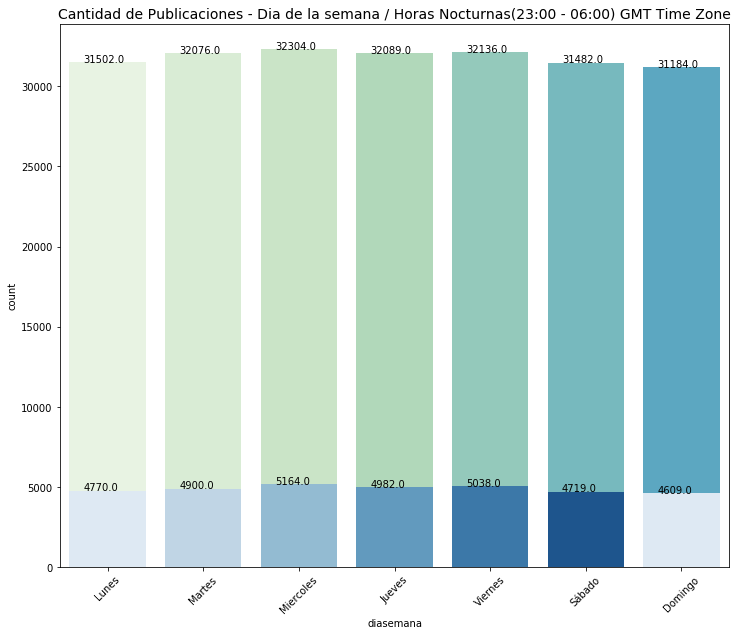

In [17]:
ddf_wd = ddf[["diasemana","hora","horas_nocturnas"]]
ddf_wd1 = (ddf_wd.loc[(ddf_wd['horas_nocturnas'] != 0)])

days = ["Lunes","Martes","Miercoles","Jueves","Viernes","Sábado","Domingo"]

fig, ax =plt.subplots(figsize=(12,10))
#plt.figure(figsize=(10,8))
ax = sns.countplot(ddf_wd['diasemana'].compute(),label="Count",palette=sns.color_palette("GnBu",10)) 
ax = sns.countplot(ddf_wd1['diasemana'].compute(),label="Count",palette=sns.color_palette("Blues")) 
ax.set_xticklabels(days, rotation=45)
plt.title("Cantidad de Publicaciones - Dia de la semana / Horas Nocturnas(23:00 - 06:00) GMT Time Zone",size=14)
for p in ax.patches:
        ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.15, p.get_height()+1))


*La tendencia por dia muestra que el pico mas alto son los miercoles, al igual que en horas nocturna.*

<a id='section8.0'></a>
### 8. Tokenización

In [18]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub(r'\S*@\S*\s?', '', sent)  # borra los emails
        sent = re.sub(r'\$\w*','', sent) # Remove tickers
        sent = re.sub(r'\s+', ' ', sent)  # borra los caracteres
        sent = re.sub(r"\'", "", sent)  # borra las comillas
        sent = re.sub(r'https?:\/\/.*\/\w*','', sent) # borra hyperlinks
        tokenized = word_tokenize(sent) # Tokeniza
        tokenized = gensim.utils.simple_preprocess(str(tokenized), deacc=True) # borra puntuación
        yield(tokenized) 
        
ddf_text = ddf.cadena.compute().tolist()
ddf_text1 = [x.lower() for x in ddf_text]; ddf_text1

data_words = list(sent_to_words(ddf_text1))

<a id='section9.0'></a>
### 9. Remover Stop Words

In [19]:
from nltk.corpus import stopwords

stopwords=stopwords.words('english')
english_vocab = set(w.lower() for w in nltk.corpus.words.words())

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stopwords and len(word) > 2 and word in english_vocab] for doc in texts]

data_words_nostops = remove_stopwords(data_words)

<a id='section10.0'></a>
### 10. Steaming y Lematización Words

In [20]:
#steaming
def steam_word (data):
    stemmer = PorterStemmer()
    return [[stemmer.stem(i.lower()) for i in tok] for tok in data]
 
data_words_steam= steam_word(data_words_nostops)

In [21]:
#Lematizacion
def lemmatized_text(corpus):
    lemmatizer = WordNetLemmatizer()
    return [' '.join([lemmatizer.lemmatize(word) for word in text]) for text in corpus]

data_words_lemmatized = lemmatized_text(data_words_steam)

In [22]:
cleaned_cadena = []
for tw in data_words_lemmatized:  
    cleaned_cadena.append(tw)

df_p = pd.DataFrame(cleaned_cadena,columns=['cleaned_cadena'])
ddf = dd.concat([ddf, df_p['cleaned_cadena']] ,axis=1)


<a id='section11.0'></a>
### 11. Polaridad y Detección de Lexico 

Para detectar la polaridad del texto, si es negativo o positivo, se utiliza la libreria de nltk.sentiment.vader import SentimentIntensityAnalyzer se establece un threshold de 0.1, para que el score mayor al threshold determine 1 si es positivo o en caso contrario 0 si es negativo.

In [23]:
#Se utiliza la libreria SentimentIntensityAnalyzer

def sentiment_value(paragraph,threshold):
    score = []
    analyser = SentimentIntensityAnalyzer()
    for sent in paragraph:
        result = analyser.polarity_scores(sent)
        score.append( 1 if (result['compound']) >= threshold else 0)
    return score
     

sample = ddf.cleaned_cadena.compute().tolist()
df_sent = pd.DataFrame(sentiment_value(sample,0.1),columns=['polaridad'])
ddf = dd.concat([ddf, df_sent['polaridad']] ,axis=1)

### Vectorización y validación del Sentimiento

In [24]:
import joblib
from sklearn.externals.joblib import parallel_backend

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC

target = ddf.polaridad.compute().tolist()

with joblib.parallel_backend('dask'):
    ngram_vectorizer = CountVectorizer(binary=True, ngram_range=(1, 3))
    ngram_vectorizer.fit(data_words_lemmatized)
    X = ngram_vectorizer.transform(data_words_lemmatized)
    X_test = ngram_vectorizer.transform(data_words_lemmatized)

    X_train, X_val, y_train, y_val = train_test_split( X, target, train_size = 0.75)

    for c in [0.001, 0.005, 0.01, 0.05, 0.1]:
        svm = LinearSVC(C=c)
        svm.fit(X_train, y_train)
        print ("Accuracy for C=%s: %s"% (c, accuracy_score(y_val, svm.predict(X_val))))
    
    final = LinearSVC(C=0.1)
    final.fit(X, target)
    print ("Final Accuracy: %s" % accuracy_score(target, final.predict(X_test)))

c:\python\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


Accuracy for C=0.001: 0.8934355585879987
Accuracy for C=0.005: 0.9303874744137609
Accuracy for C=0.01: 0.9388264445003053
Accuracy for C=0.05: 0.9508205551765002
Accuracy for C=0.1: 0.9530290516034043
Final Accuracy: 0.9991022251350029


*Para validar la clasificación de sentimiento, Se realiza validación del sentimiento utilizando CountVectorizer y ngram con el algoritmo LinearSVC, el clasificador es muy bueno con un accuracy de 0.99*

In [25]:
feature_to_coef = {
    word: coef for word, coef in zip(
        ngram_vectorizer.get_feature_names(), final.coef_[0]
    )
}
pos = []
neg = []
for best_positive in sorted(feature_to_coef.items(),key=lambda x: x[1],reverse=True)[:60]:
    #print (best_positive)
    pos.append(best_positive[0])

    
print("\n\n")
for best_negative in sorted(feature_to_coef.items(),key=lambda x: x[1])[:60]:
    #print (best_negative)
    neg.append(best_negative[0])
    

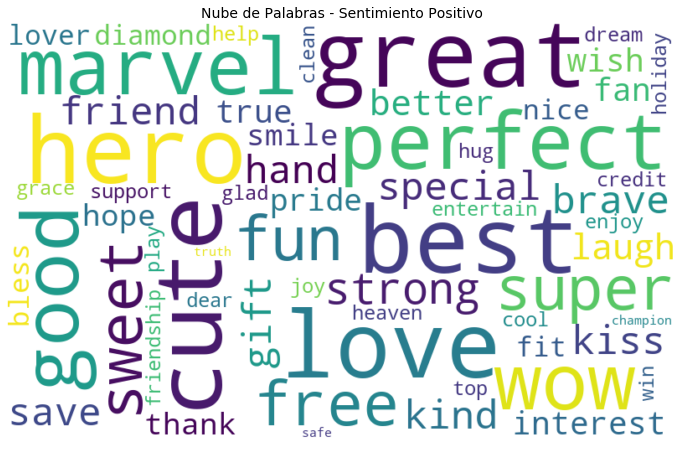

In [26]:
from wordcloud import WordCloud

all_words_pos = ' '.join([text for text in list(pos)])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110,background_color="white").generate(all_words_pos)

plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.title("Nube de Palabras - Sentimiento Positivo",size=14)
plt.axis('off')
plt.show()

*La nube de palabras con sentimiento positivo, muestra palabras mas destacadas como 'love', 'hero', 'best', 'great', 'cute', 'perfect'*

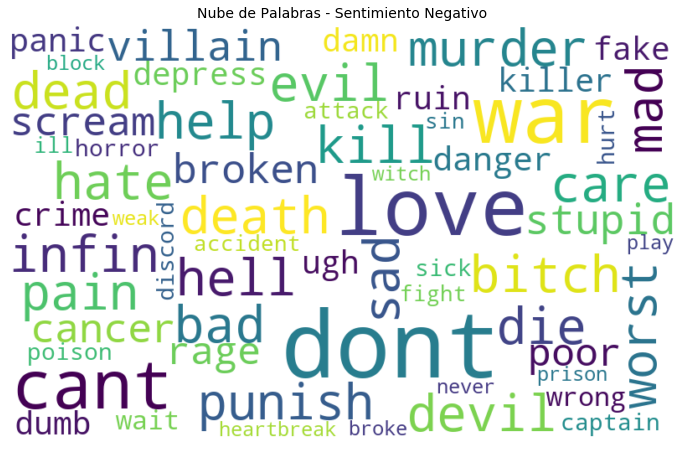

In [27]:
from wordcloud import WordCloud

all_words_neg = ' '.join([text for text in list(neg)])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110,background_color="white").generate(all_words_neg)

plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.title("Nube de Palabras - Sentimiento Negativo",size=14)
plt.axis('off')
plt.show()

*La nube de palabras con sentiiento negativo, muestra las palabras destacadas como 'hell','dead','death','dont love','kill','bitch','evil','murder','bad' etc.*

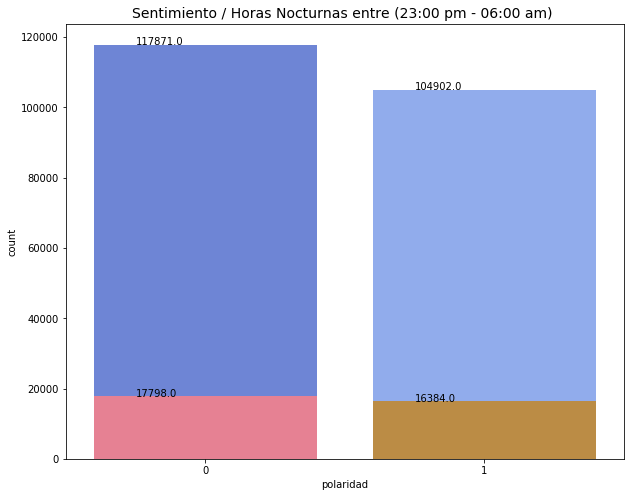

In [28]:
ddf_sm = ddf[["hora","horas_nocturnas","polaridad"]]
ddf_sm1 = (ddf_sm.loc[(ddf_sm['horas_nocturnas'] != 0)])
fig, ax =plt.subplots(figsize=(10,8))
ax = sns.countplot(ddf_sm['polaridad'].compute(),label="Count",palette=sns.color_palette("coolwarm",8)) 
ax = sns.countplot(ddf_sm1['polaridad'].compute(),label="Count",palette=sns.color_palette("husl",8)) 
plt.title("Sentimiento / Horas Nocturnas entre (23:00 pm - 06:00 am) ",size=14)
for p in ax.patches:
        ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.15, p.get_height()+1))

*La gráfica muestra que la cantidad de sentimiento negativo es mayor que de sentimiento positivo, sin embargo, la diferencia en horas nocturas no es muy significativa.*

<a id='section12.0'></a>
### 12. Lenguaje Depresivo

*Para el lenguaje depresivo se genera un corpus manual de palabras depresivas como 'fat', 'bad', 'weak', 'problem', 'tired', 'illusion', 'restless', 'bored', 'crap', 'shit', 'fuck', etc. Adicionando las palabras mas destacas de negativas, se buscan los sinonimos de estas con la libreria Wornet*

In [21]:
neg = pd.read_csv('NegEmotions.txt',header=0)
neg1 = pd.DataFrame(pos)
neg1.rename(columns={0: 'Emotion'}, inplace=True)
neg_u = neg1.append(neg)
neg_u.reset_index(drop=True,inplace=True)

In [22]:
#Generación de variable lenguaje depresivo.
def leng_depresivo(w_pos,data):
    
    sin_pos = []

    for n, _ in enumerate(w_pos['Emotion']):
        for syn in wordnet.synsets(_):
            for lemma in syn.lemmas():
                sin_pos.append(lemma.name())

    mylist = list(dict.fromkeys(sin_pos))
    
    lista = []
    numero = []
    for num,mx in enumerate(data):
        #print(num, mx)
        lista.append(0)
        for i in list(mx):
            if i in list(mylist):
                #print(num,i)
                numero.append(num)
            
    numero = list(dict.fromkeys(numero))
    for i,j in enumerate(numero):
        lista[j]=1
    return lista


lista_leng = leng_depresivo(neg_u,data_words_nostops)

dfl = pd.DataFrame(lista_leng,columns=['len_depresivo'])
ddf = dd.concat([ddf, dfl['len_depresivo']] ,axis=1)


In [24]:
columns=['cleaned_cadena','dia_laborable','horas_nocturnas','frecuencia',
         'polaridad','len_depresivo','note_count','type_x']
ddf_x = ddf[columns]
corr =  ddf_x.corr().compute()
corr

,dia_laborable,horas_nocturnas,frecuencia,polaridad,len_depresivo,note_count,type_x
dia_laborable,1.000000,0.007961,0.003728,0.000878,0.000156,-0.001396,0.001668
horas_nocturnas,0.007961,1.000000,0.008993,0.007186,0.009634,-0.000967,-0.000583
frecuencia,0.003728,0.008993,1.000000,-0.009785,0.010628,0.000763,-0.013470
polaridad,0.000878,0.007186,-0.009785,1.000000,0.401016,0.008154,0.012118
len_depresivo,0.000156,0.009634,0.010628,0.401016,1.000000,0.010413,0.016031
note_count,-0.001396,-0.000967,0.000763,0.008154,0.010413,1.000000,-0.008083
type_x,0.001668,-0.000583,-0.013470,0.012118,0.016031,-0.008083,1.000000


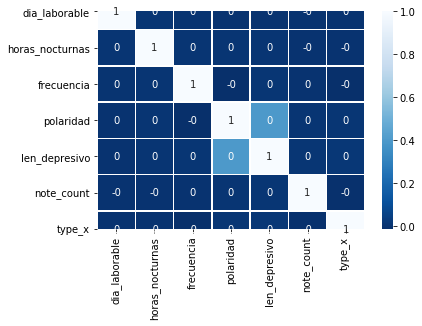

In [25]:
f, ax = plt.subplots(figsize=(6,4))
sns.heatmap(corr, annot = True, fmt = ".0f", linewidths = .5, cmap = 'Blues_r')

*La correlacion no evidencia mayor relavancia, pero se puede ver que hay una correlación entre el lenguaje depresivo, la hora y el sentimiento*

In [26]:
def metricas_modelos(y_true, y_pred):
    from sklearn.metrics import accuracy_score, auc, confusion_matrix, f1_score, precision_score, recall_score, roc_curve, roc_auc_score

    # Obtención de matriz de confusión
    confusion_matrix = confusion_matrix(y_true, y_pred)
    
    print('La matriz de confusión es ')
    print(confusion_matrix)
    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix, annot = True, fmt = ".0f", linewidths = .5, cmap = 'Blues_r');
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');

    print('Precisión:', accuracy_score(y_true, y_pred))
    print('Exactitud:', precision_score(y_true, y_pred))
    print('Exhaustividad:', recall_score(y_true, y_pred))
    print('F1:', f1_score(y_true, y_pred))

    false_positive_rate, recall, thresholds = roc_curve(y_true, y_pred)
    roc_auc = auc(false_positive_rate, recall)

    print('AUC:', roc_auc)
    
    #fpr, tpr, _ = roc_curve(y_true, y_pred)
    
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.plot(false_positive_rate, recall, lw=3,label='ROC Curve (area = {:.2f})'.format(roc_auc))
    ax.plot([0, 1], [0, 1], 'k--', lw=2)
    ax.set(
    xlim=(0, 1),
    ylim=(0, 1),
    title="ROC Curve",
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    )
    ax.legend();
    plt.show()
    
    
    

<a id='section13.0'></a>
### 13. Definición de Variables

In [38]:
#Como variables predictoras se toman 'diasemana','hora','horas_nocturnas','type_x','note_count','polaridad'; 
#y como variable a predecir 'len_depresivo'
x = ddf_x[['dia_laborable','horas_nocturnas','frecuencia','note_count','polaridad','type_x']]
y = ddf_x[['len_depresivo']]

# Division de dataset de entrenamiento y de test
from dask_ml.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

In [39]:
# Variables a matrices
x_train = X_train.to_dask_array(lengths=True)
x_test = X_test.to_dask_array(lengths=True)
Y_train = y_train.to_dask_array(lengths=True)
Y_test = y_test.to_dask_array(lengths=True)

<a id='section14.0'></a>
### 14. Modelos

### Naive Bayes

In [41]:
###Algoritmo Multinomial Naive Bayes####
import joblib
from sklearn.externals.joblib import parallel_backend
#from sklearn.feature_extraction.text import TfidfVectorizer 
#from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

clf = MultinomialNB() 
MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

with joblib.parallel_backend('dask'):
    clf.fit(x_train.compute(), Y_train.compute())

y_pred = clf.predict(x_test.compute())
print("Algoritmo Multinomial Naive Bayes")
print("Entrenamiento:", clf.score(x_train.compute(), Y_train.compute()))
print("Validación:", clf.score(x_test.compute(),Y_test.compute()))



c:\python\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Algoritmo Multinomial Naive Bayes
Entrenamiento: 0.6997013165147611
Validación: 0.7019549097445884


La matriz de confusión es 
[[ 8312  8181]
 [11715 38547]]
Precisión: 0.7019549097445884
Exactitud: 0.8249229583975347
Exhaustividad: 0.7669213322191716
F1: 0.7948654500463965
AUC: 0.6354463570087552


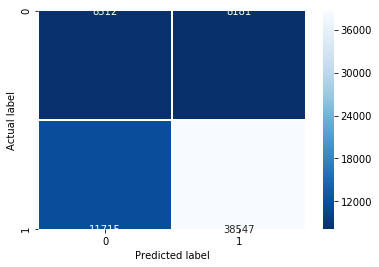

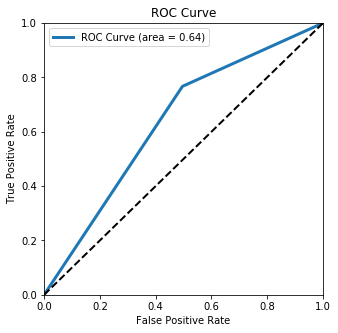

In [42]:
metricas_modelos(Y_test.compute(), y_pred)

### Random Forest

In [43]:
from sklearn.ensemble import RandomForestClassifier

   
clf_rf = RandomForestClassifier(n_estimators=250,
                                max_depth=3,
                                n_jobs=-1)

with joblib.parallel_backend('dask'):
    clf_rf.fit(x_train.compute(), Y_train.compute())

y1_pred = clf_rf.predict(x_test.compute())

print("Algoritmo Random Forest")
print("Entrenamiento:", clf_rf.score(x_train.compute(), Y_train.compute()))
print("Validación:", clf_rf.score(x_test.compute(), Y_test.compute()))


c:\python\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


Algoritmo Random Forest
Entrenamiento: 0.7513940699150098
Validación: 0.7529323646168826


La matriz de confusión es 
[[    0 16493]
 [    0 50262]]
Precisión: 0.7529323646168826
Exactitud: 0.7529323646168826
Exhaustividad: 1.0
F1: 0.8590546672705676
AUC: 0.5


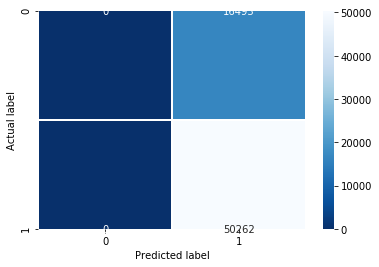

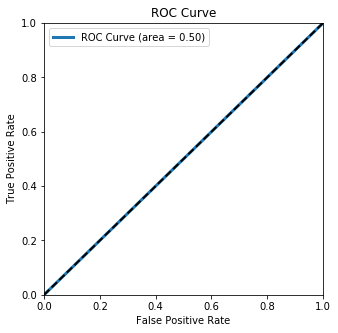

In [44]:
metricas_modelos(Y_test.compute(), y1_pred)

### Voting Classifier

In [45]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

classifiers = [
    ('sgd', SGDClassifier(max_iter=1000)),
    ('logisticregression', LogisticRegression()),
    ('svc', SVC(gamma='auto')),
]
clf_v = VotingClassifier(classifiers, n_jobs=-1)

with joblib.parallel_backend("dask"):
    clf_v.fit(x_train.compute(), Y_train.compute())

y2_pred = clf_v.predict(x_test.compute())

print("Algoritmos Clasificación por Votos")
print("Entrenamiento:", clf_v.score(x_train.compute(), Y_train.compute()))
print("Validación:", clf_v.score(x_test.compute(), Y_test.compute()))




c:\python\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\python\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


Algoritmos Clasificación por Votos


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


Entrenamiento: 0.7528810778243537


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


Validación: 0.7539809752078496


La matriz de confusión es 
[[  339 16154]
 [  269 49993]]
Precisión: 0.7539809752078496
Exactitud: 0.7557863546343749
Exhaustividad: 0.9946480442481398
F1: 0.8589198429674682
AUC: 0.5076011093732059


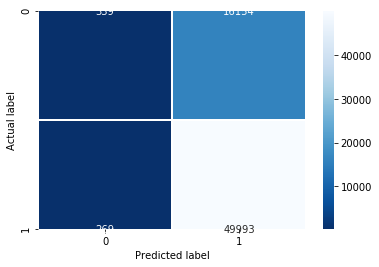

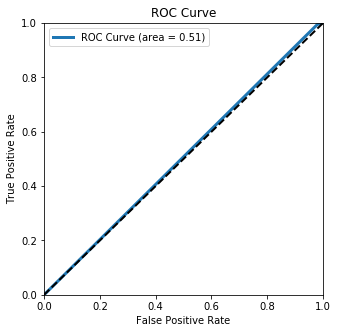

In [46]:
metricas_modelos(Y_test.compute(),y2_pred)

### XgBoost

In [47]:
import dask_xgboost as dxgb
from sklearn.metrics import roc_auc_score, roc_curve

params = {'objective': 'binary:logistic', 'nround': 1000,
          'max_depth': 3, 'eta': 0.1, 'subsample': 0.8,
          'min_child_weight': 1, 'tree_method': 'hist',
          'grow_policy': 'lossguide'}

bst = dxgb.train(client, params, x_train, Y_train)

y3_pred = dxgb.predict(client, bst, x_test).persist()
y3_pred

print("Algoritmo XgBoost")
print("Validacion : ",roc_auc_score(Y_test.compute(),y3_pred.compute()))

Algoritmo XgBoost


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


Validacion :  0.7668241611675068


La matriz de confusión es 
[[  268 16225]
 [  187 50075]]
Precisión: 0.7541457568721444
Exactitud: 0.7552790346907994
Exhaustividad: 0.9962794954438741
F1: 0.8591993960295807
AUC: 0.5062644066681566


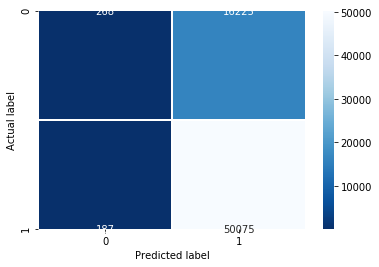

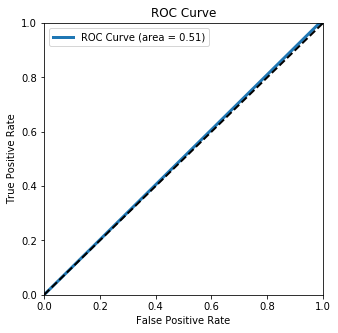

distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


In [48]:
metricas_modelos(Y_test.compute(),y3_pred.compute().round())

<a id='section15.0'></a>
### 15. Conclusiones

Se utilizaron diversas características lingüísticas como la presencia de palabras relacionadas a el trastorno de depresión, semánticas como el sentimiento en las publicaciones, y de actividad como los días y/o horas en que se realiza la publicación, para detectar las publicaciones depresivas.
Se evaluaron varios algoritmos de clasificación, comparando las medidas de precisión, Exactitud, Exhaustividad y teniendo en cuenta los métodos de evaluación de rendimiento como ROC y AUC. 
Se demostró que el algoritmo más acertado para la clasificación de las publicaciones depresivas es XgBoost sobre el framework de Dask con 76% de accuracy.